In [1]:
### v1.2

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate


# <a name='2'></a>
##  Load and Split the Data

In [3]:
import os
import numpy as np 
import pandas as pd 
import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

Text(0.5, 1.0, 'Segmentation')

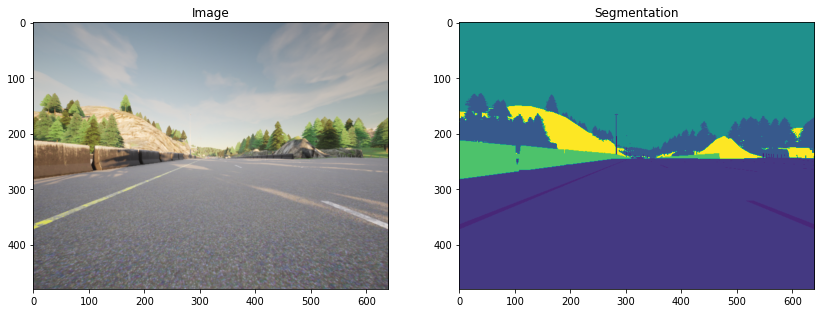

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
###  Split Your Dataset into Unmasked and Masked Images

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/002128.png', shape=(), dtype=string)


## Preprocess Your Data


In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [8]:
# Get the dataset size
dataset_size = processed_image_ds.cardinality().numpy()

# Define split sizes
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # 20% for testing

# Split the dataset
train_dataset = processed_image_ds.take(train_size)
test_dataset = processed_image_ds.skip(train_size)


In [9]:
train_dataset

<TakeDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>

In [10]:
test_dataset

<SkipDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>

In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """


    conv = Conv2D(n_filters,
                  3,   
                  activation="relu",
                  padding= "same",
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   
                  activation="relu",
                  padding= "same",
                  kernel_initializer='he_normal')(conv)
    
    
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)

        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [12]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    

    up = Conv2DTranspose(
                 n_filters,   
                 3,   
                 strides= (2,2),
                 padding= "same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters,   
                 3,     # Kernel size
                 activation= "relu",
                 padding= "same",
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  
                 3,   
                 activation= "relu",
                 padding= "same",
                 kernel_initializer= "he_normal")(conv)

    
    return conv

In [13]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    
    cblock1 = conv_block(inputs, n_filters )
    
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8 , dropout_prob= 0.3) 
    
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob= 0.3, max_pooling=False) 
    
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters )


    conv9 = Conv2D(n_filters,
                   3,
                 activation='relu',
                 padding='same',
                 kernel_initializer= 'he_normal')(ublock9)

  
    conv10 = Conv2D( n_classes,
                    1,
                    padding= "same") (conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### Set Model Dimensions

In [14]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [15]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [16]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


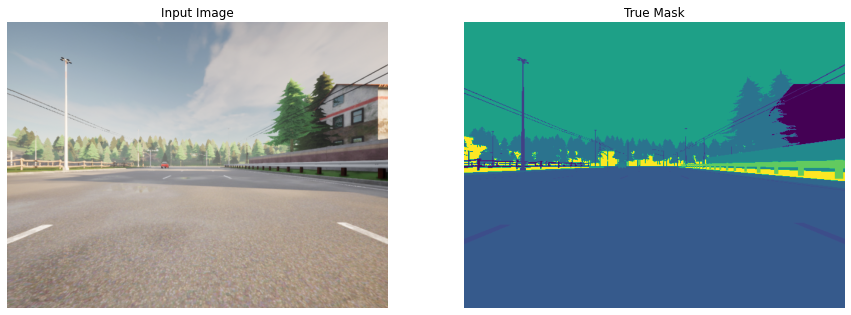

In [18]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


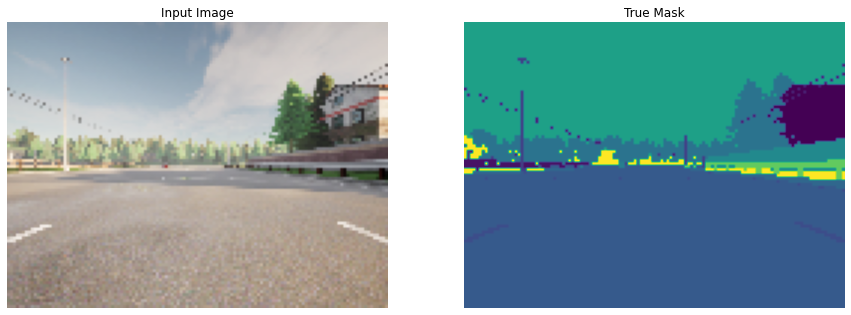

In [19]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [20]:
train_dataset

<TakeDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>

<a name='4'></a>
##  Train the Model

In [21]:
EPOCHS = 29
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset.element_spec)


(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.uint8, name=None))


In [22]:
model_history = unet.fit(train_dataset, epochs=EPOCHS)

Epoch 1/29
27/27 [==============================] - 16s 184ms/step - loss: 2.4031 - accuracy: 0.3445
Epoch 2/29
27/27 [==============================] - 1s 47ms/step - loss: 0.8782 - accuracy: 0.7681
Epoch 3/29
27/27 [==============================] - 1s 47ms/step - loss: 0.6435 - accuracy: 0.8112
Epoch 4/29
27/27 [==============================] - 1s 47ms/step - loss: 0.5431 - accuracy: 0.8342
Epoch 5/29
27/27 [==============================] - 1s 47ms/step - loss: 0.4822 - accuracy: 0.8519
Epoch 6/29
27/27 [==============================] - 1s 46ms/step - loss: 0.4306 - accuracy: 0.8675
Epoch 7/29
27/27 [==============================] - 1s 47ms/step - loss: 0.3761 - accuracy: 0.8849
Epoch 8/29
27/27 [==============================] - 1s 47ms/step - loss: 0.3305 - accuracy: 0.9029
Epoch 9/29
27/27 [==============================] - 1s 47ms/step - loss: 0.3097 - accuracy: 0.9094
Epoch 10/29
27/27 [==============================] - 1s 47ms/step - loss: 0.2711 - accuracy: 0.9216
Epoch 1

<a name='4-1'></a>
###  Create Predicted Masks 

In [23]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
###  Plot Model Accuracy


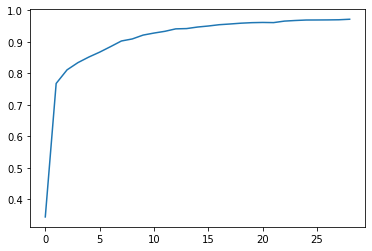

In [24]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
###  Show Predictions 



In [25]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 201ms/step


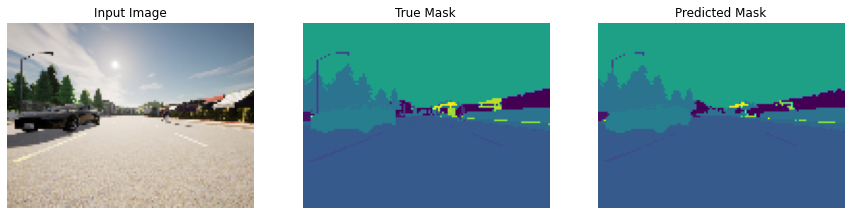

1/1 [==============================] - 0s 23ms/step


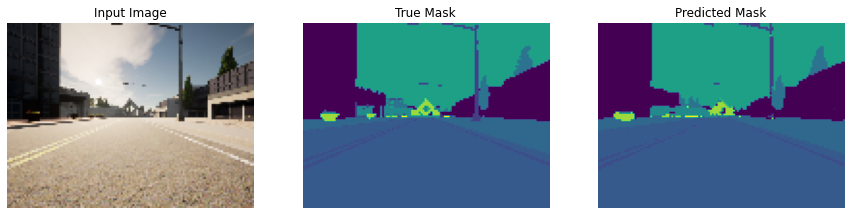

1/1 [==============================] - 0s 24ms/step


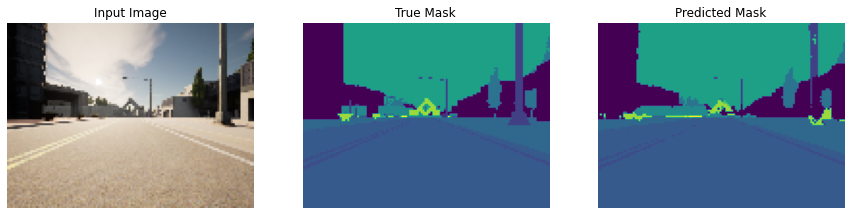

In [26]:
show_predictions(train_dataset, 3)

In [27]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.uint8, name=None))>

In [28]:
test_dataset = test_dataset.map(lambda x, y: (tf.expand_dims(x, axis=0), tf.expand_dims(y, axis=0)))


1/1 [==============================] - 1s 1s/step


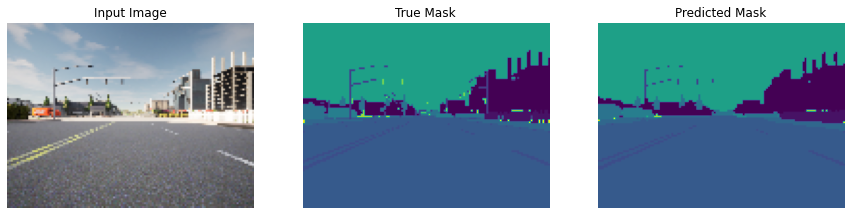

1/1 [==============================] - 0s 23ms/step


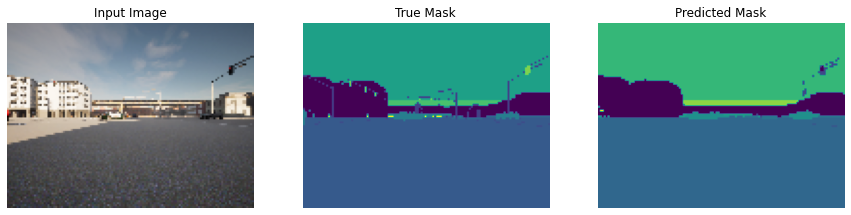

1/1 [==============================] - 0s 23ms/step


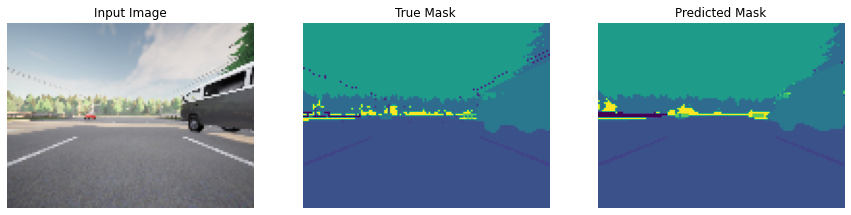

1/1 [==============================] - 0s 23ms/step


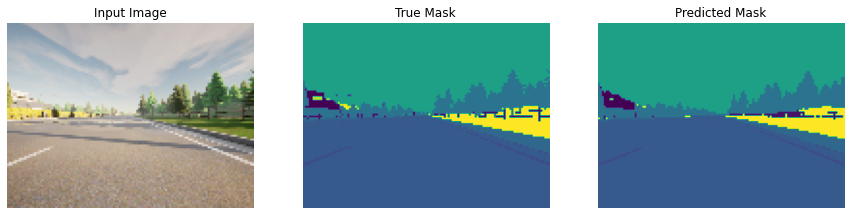

1/1 [==============================] - 0s 23ms/step


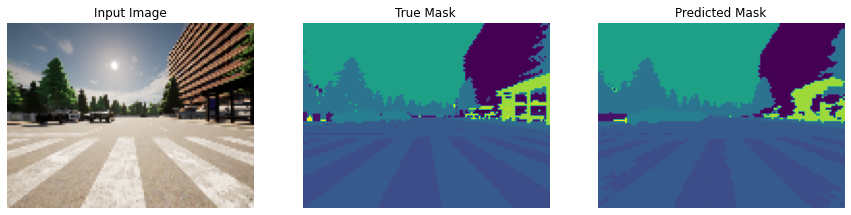

1/1 [==============================] - 0s 23ms/step


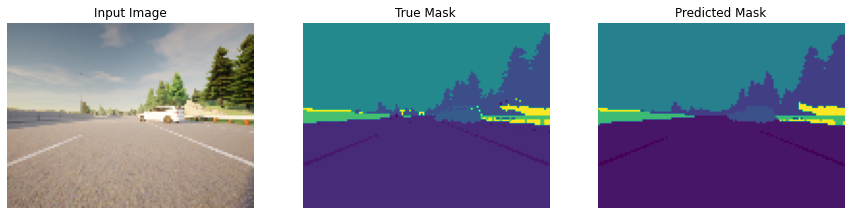

1/1 [==============================] - 0s 23ms/step


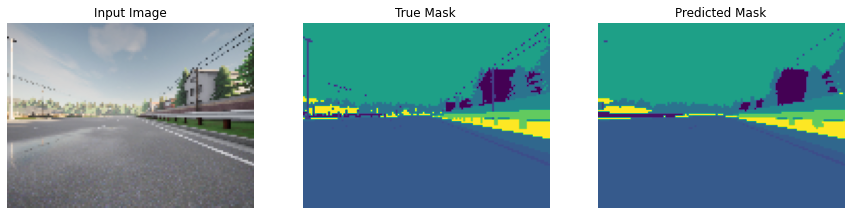

1/1 [==============================] - 0s 23ms/step


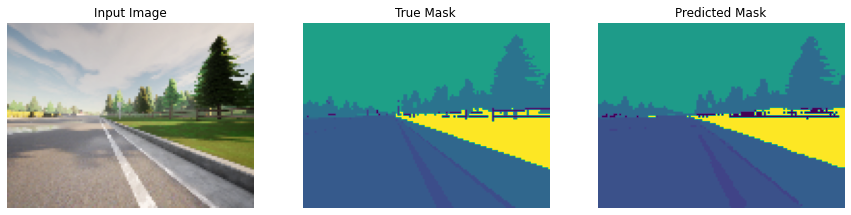

In [29]:
show_predictions(test_dataset, 8)